# Search Engine

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import os
def time_elapsed(s):
    '''
    Function to establish baselines for time needed to setup a search engine
    '''
    print("Time Elapsed: {} seconds".format(round(time.time() - s, 4)))

## Importing embedding nets

In [3]:
import pickle

In [4]:
s = time.time()
text_net = pickle.load(open("pickles/models/entire_nuswide_model.p", "rb"))
def get_text_embedding(*data):
    return text_net.text_embedding_net(data[0])
text_net.get_embedding = get_text_embedding

image_net = pickle.load(open("pickles/models/entire_nuswide_model.p", "rb"))
time_elapsed(s)

Time Elapsed: 5.3674 seconds


## Importing datasets

`modality_data[i]` should return `(tensor, index)` of ith item

`modality_from_idx[i]` should return `value` of ith item

#### Image Dataset (NUS-WIDE)

In [5]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [6]:
s = time.time()

image_directory = 'data/Flickr'
image_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

image_data = ImageFolder('data/Flickr', transform = image_transform)
image_from_idx = [i[0] for i in image_data.samples]

time_elapsed(s)

Time Elapsed: 7.0157 seconds


#### Text Dataset (word2vec)

In [7]:
s = time.time()

word2vec_dict = pickle.load(open("pickles/word_embeddings/word_embeddings_tensors.p", "rb"))

time_elapsed(s)

Time Elapsed: 65.3254 seconds


In [8]:
s = time.time()

text_from_idx = [None] * len(word2vec_dict)
text_data = [None] * len(word2vec_dict)
for idx, (key, value) in enumerate(word2vec_dict.items()):
    text_from_idx[idx] = key
    text_data[idx] = (value, idx)

time_elapsed(s)

Time Elapsed: 0.7416 seconds


## Creating Data Loaders

Need to enable batch processing of data for GPU acceleration

In [9]:
from torch.cuda import is_available

batch_size = 128
cuda = is_available()
kwargs = {'num_workers': 4, 'pin_memory': True} if cuda else {}

In [11]:
from torch.utils.data import DataLoader

image_dataloader = DataLoader(image_data, batch_size = batch_size, **kwargs)
text_dataloader = DataLoader(text_data, batch_size = batch_size, **kwargs)

## Setting up SearchEngines

In [184]:
from search import SearchEngine

In [185]:
save_directory = './embeddings'

In [186]:
search_engine = SearchEngine(["text", "image"], cuda = cuda, save_directory = save_directory, verbose = True)

In [187]:
search_engine.add_model(text_net, "text_net", "text", (300,) , 30)
search_engine.add_model(image_net, "image_net", "image", (3, 224, 224), 30)

In [188]:
search_engine.add_dataset("wiki_word2vec", text_dataloader, text_from_idx, "text", (300,))
search_engine.add_dataset("nus-wide", image_dataloader, image_from_idx, "image", (3, 224, 224))

## Indexing data in SearchEngines

In [189]:
search_engine.build_index("wiki_word2vec")

Building text_net index
Batch 0 of 10000
Batch 1000 of 10000
Batch 2000 of 10000
Batch 3000 of 10000
Batch 4000 of 10000
Batch 5000 of 10000
Batch 6000 of 10000
Batch 7000 of 10000
Finished building text_net index in 4.8821 seconds.


In [190]:
search_engine.build_index("nus-wide")

Building image_net index
Batch 0 of 10000
Batch 1000 of 10000
Batch 2000 of 10000
Finished building image_net index in 1.3127 seconds.


## Queries

In [209]:
import matplotlib.pyplot as plt

def target_to_tensor(target, modality):
    if modality == "image":
        tensor = image_transform(target)
    elif modality == "text":
        tensor = word2vec_dict[target]
    return tensor
    
def search(target, modality, n=5):
    tensor = target_to_tensor(target, modality).detach().to("cuda")
    model_name = search_engine.valid_models(tensor, modality)[0]
    embedding = search_engine.models[model_name].get_embedding(tensor[None,:,:,:])[0]
    results = []
    for index_key in search_engine.valid_indexes(embedding):
        dis, idx = search_engine.search(embedding, index_key, n = n)
        results.append([[index_key, dis, idx]])
    return results

In [210]:
search_engine.data_from_idx('nus-wide', [7,6])

['data/Flickr/actor/0008_2217003708.jpg',
 'data/Flickr/actor/0007_25158805.jpg']

In [211]:
search_engine.data_from_idx('wiki_word2vec', [4343,6534])

['amid', 'Idaho']

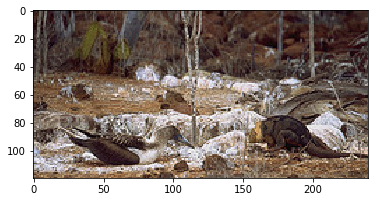

In [220]:
import random
import PIL

image = image_from_idx[random.randint(0,len(image_from_idx))]
image = PIL.Image.open(image)
image_tensor = image_transform(image)
plt.imshow(image)

In [222]:
results = search(image, "image")


In [224]:
results

[[[('wiki_word2vec', 'text_net', False),
   array([[2.1763802, 2.2056274, 2.3708477, 2.3789744, 2.394052 ]],
         dtype=float32),
   array([[ 4911,  7374, 32354,  7808, 49540]])]],
 [[('nus-wide', 'image_net', False),
   array([[2.3841858e-07, 1.2621737e-01, 1.3525629e-01, 1.4265704e-01,
           1.4921761e-01]], dtype=float32),
   array([[ 30122,  30290,  30195, 269378,   4582]])]]]

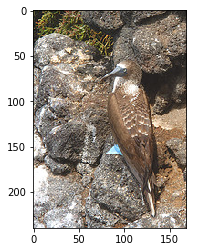

In [230]:
image = search_engine.data_from_idx('nus-wide', [30290])[0]
image = PIL.Image.open(image)
plt.imshow(image)

In [196]:
search_engine.indexes[('nus-wide','image_net',False)]
search_engine.models['image_net'].output_dimension

30

In [166]:
query_and_display('balloon', 'text', image_search_engine)

NameError: name 'query_and_display' is not defined

In [ ]:
embedding = target_to_embedding(image, "image")
distances, idx = text_search_engine.search(embedding, n=5, verbose = True)